In [1]:
### Import the required libraries
import numpy as np
import scipy
import matplotlib.pyplot as plt
import cmocean

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import tensorflow as tf
import tensorflow.keras as keras
from keras import metrics
import innvestigate
from sklearn.model_selection import train_test_split

import os
from os.path import join
import sys

import xarray as xr
import xmitgcm
from xmitgcm import open_mdsdataset
import ecco_v4_py as ecco

import random

# See if GPUs are available
from keras import backend as K
if bool(K._get_available_gpus()):
    print("Running on GPU")
else:
    print("Running on CPU")

# Append to sys.path the absolute path to src/XAIRT
path_list = os.path.abspath('').split('/')
path_src_XAIRT = ''
for link in path_list[:-1]:
    path_src_XAIRT = path_src_XAIRT+link+'/'
sys.path.append(path_src_XAIRT+'/src')

# Now import module XAIRT
from XAIRT import *

### https://stackoverflow.com/questions/36288235/how-to-get-stable-results-with-tensorflow-setting-random-seed ###
### https://keras.io/examples/keras_recipes/reproducibility_recipes/ ###
SEED = 1997
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

tf.compat.v1.disable_eager_execution()

2024-09-02 12:47:08.206871: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-02 12:47:25.419854: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 12:47:25.480553: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 12:47:25.482989: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/rep

Running on GPU


In [2]:
### Sverdrup 
# mainDir_r4  = '/scratch2/pillarh/eccov4r4'
# mainDir_r5  = '/scratch2/pillarh/eccov4r5'
# gridDir  = mainDir_r4 + '/GRID'
# thetaDir = mainDir_r5 + '/V4r5/diags_daily/SST_day_mean'
# thetaDir_ext = mainDir_r5 + '/V4r5_ext_2020_2023_Jun/diags_daily/SST_day_mean'

## LS6
mainDir_r4 = '/work/07665/shrey911/ls6/LRP_eccov4r4_data'
mainDir_r5 = '/work/07665/shrey911/ls6/LRP_eccov4r5_data'
gridDir  = mainDir_r5 + '/GRID'
thetaDir = mainDir_r5 + '/SST_day_mean'
thetaDir_ext = mainDir_r5 + '/SST_day_mean_ext_2020_2023_Jun'

# For Sverdrup
# ds_r4 = xr.open_dataset(f'/scratch2/shreyas/LRP_eccov4r4_data/thetaSurfECCOv4r4.nc')
# For LS6
ds_r4 = xr.open_dataset(mainDir_r4 + '/thetaSurfECCOv4r4.nc')

# SSH has to be kept because someone used the SSH metadata for SST, 
# It's not a bug in this code but a hack to handle an existing bug.
temp = xmitgcm.open_mdsdataset(data_dir = thetaDir,
                             grid_dir = gridDir,
                             extra_variables = dict(SSH = dict(dims=['k','j','i'],
                                                               attrs = dict(standard_name="SST",
                                                                            long_name="Sea Surface Temperature",
                                                                            units="degC"))))
temp["SST"] = temp["SSH"]
temp = temp.drop(["SSH"])
    
temp_ext = xmitgcm.open_mdsdataset(data_dir = thetaDir_ext,
                                 grid_dir = gridDir,
                                 extra_variables = dict(SST = dict(dims=['k','j','i'],
                                                                   attrs = dict(standard_name="SST",
                                                                                long_name="Sea Surface Temperature",
                                                                                units="degC"))))

ds_r5 = xr.concat([temp, temp_ext], "time")

In [3]:
ds_SST = xr.open_dataset(mainDir_r5+'/SST_all.nc')
SST = ds_SST['SST'].data

In [4]:
hFacC = ecco.read_llc_to_tiles(gridDir, 'hFacC.data')
hFacC_mask = hFacC > 0
hFacC_mask = hFacC_mask.astype(float)

XC = ds_r4['XC'].data
YC = ds_r4['YC'].data

latMask = YC > -20.0
latMask = latMask.astype(float)

maskFinal = hFacC_mask * latMask
NaNmaskFinal = np.copy(maskFinal)
NaNmaskFinal[NaNmaskFinal == 0] = np.nan

da_XC = xr.DataArray(
    data=ds_r4['XC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="XC"),
)

da_YC = xr.DataArray(
    data=ds_r4['YC'].data,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="YC"),
)

da_hFacC_mask = xr.DataArray(
    data=hFacC_mask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="hFacC mask 2D 1 if > 0, else 0"),
)

da_latMask = xr.DataArray(
    data=latMask,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Latitude Mask 1 if > -20, else 0"),
)

da_maskFinal = xr.DataArray(
    data=maskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D 1 if > 0, else 0"),
)

da_NaNmaskFinal = xr.DataArray(
    data=NaNmaskFinal,
    dims=["tile", "j", "i"],
    coords=dict(
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="Mask 2D True if > 0, else NaN"),
)

wetpoints = np.nonzero(maskFinal.data)
da_wetpoints = xr.DataArray(
    data=np.asarray(wetpoints),
    dims=["wetpoints_dim", "num_wetpoints"],
    coords=dict(
        wetpoints_dim = np.arange(np.asarray(wetpoints).shape[0], dtype = int),
        num_wetpoints = np.arange(np.asarray(wetpoints).shape[1], dtype = int),
    ),
    attrs=dict(description="indices of wetpoints in the order (tile, j, i) in the three rows"),
)

da_SST = xr.DataArray(
    data=SST,
    dims=["time", "tile", "j", "i"],
    coords=dict(
        time = ds_r5['time'].data[:SST.shape[0]],
        tile = ds_r4['tile'].data,
        j    = ds_r4['j'].data,
        i    = ds_r4['i'].data,
    ),
    attrs=dict(description="SST field in llc format"),
)

ds = xr.Dataset()
ds = ds.assign(XC           = da_XC,
               YC           = da_YC,
               hFacC_mask   = da_hFacC_mask,
               latMask      = da_latMask,
               maskFinal    = da_maskFinal,
               NaNmaskFinal = da_NaNmaskFinal,
               wetpoints    = da_wetpoints,
               SST          = da_SST)

load_binary_array: loading file /work/07665/shrey911/ls6/LRP_eccov4r5_data/GRID/hFacC.data
load_binary_array: data array shape  (1170, 90)
load_binary_array: data array type  >f4
llc_compact_to_faces: dims, llc  (1170, 90) 90
llc_compact_to_faces: data_compact array type  >f4
llc_faces_to_tiles: data_tiles shape  (13, 90, 90)
llc_faces_to_tiles: data_tiles dtype  >f4


In [5]:
def anomalize_new(field, num_years = 31, first_leap_year_idx = 0):
    
    leap_yr_offsets_jan_feb   = np.array([0,1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8])
    leap_yr_offsets_after_feb = np.array([1,1,1,1,2,2,2,2,3,3,3,3,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8])

    if len(field.shape) > 1:
        seasonal_trend = np.zeros((366, field.shape[1]))
    else:
        seasonal_trend = np.zeros((366,))

    #### Calculate seasonal trend
    
    # Jan 1 - Feb 28
    for d in range(59):
        same_cal_days_idx=[d+365*year+leap_yr_offsets_jan_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)
    
    # Feb 29 starting 1996, so year 2 in 0-indexing
    same_cal_days_idx=[365*year+59+int(year/4) for year in range(first_leap_year_idx,num_years,4)]
    # Remove mean
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='constant', 
                                                    overwrite_data=False)
    # Remove linear trend
    field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                    axis=0, 
                                                    type='linear', 
                                                    overwrite_data=False)
            
    # Mar 1 - Dec 31
    for d in range(60,366):
        same_cal_days_idx=[d-1+365*year+leap_yr_offsets_after_feb[year] for year in range(num_years)]
        # Remove mean
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='constant', 
                                                        overwrite_data=False)
        # Remove linear trend
        field[same_cal_days_idx] = scipy.signal.detrend(field[same_cal_days_idx], 
                                                        axis=0, 
                                                        type='linear', 
                                                        overwrite_data=False)

    return field

In [6]:
X = ds['SST'].data[:,wetpoints[0],wetpoints[1],wetpoints[2]].copy()
X = anomalize_new(X)
X_full = X.copy()
X = X[30:-30]

y = ds['SST'].isel(tile = 10, j = 1, i = 43).data.copy()
y = anomalize_new(y)
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(y, np.ones(61)/61, mode='valid')
oneHotCost = np.zeros((y.shape[0], 2), dtype = int)
oneHotCost[:,0] = y >= 0.0
oneHotCost[:,1] = y <  0.0

In [7]:
da_X = xr.DataArray(
    data=X,
    dims=["time_allData", "num_wetpoints"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data as matrix X; deseasoned, delinearized and mean removed."),
)

da_y = xr.DataArray(
    data=y,
    dims=["time_allData"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
    ),
    attrs=dict(description="All cost function y; deseasoned, delinearized and mean removed."),
)

da_X_full = xr.DataArray(
    data=X_full,
    dims=["time", "num_wetpoints"],
    coords=dict(
        time          = ds['time'],
        num_wetpoints = ds['num_wetpoints'].data,
    ),
    attrs=dict(description="All data without accounting for conv filter as matrix X_full; deseasoned, delinearized and mean removed."),
)

da_oneHotCost = xr.DataArray(
    data=oneHotCost,
    dims=["time_allData", "NN_output_dim"],
    coords=dict(
        time_allData  = ds['time'].data[30:-30],
        NN_output_dim = np.array([0,1]),
    ),
    attrs=dict(description="All cost function as one-hot vector."),
)

ds = ds.assign(X          = da_X,
               y          = da_y,
               X_full     = da_X_full,
               oneHotCost = da_oneHotCost)

## Optimal Input

In [8]:
def quickSetup(X, y,
               test_split_frac,
               val_split_frac,
               lagSteps,
               desired_labels,
               compute_loss,
               OI_eta,
               OI_epochs,
               OI_print_freq,
               decay_func = None,
               init_type = None,
               **NNkwargs):
    
    result = {}

    idx = int(X.shape[0]*(1-test_split_frac))
    X_train = X[:idx]
    oneHotCost_train = oneHotCost[:idx]
    X_test = X[idx:]
    oneHotCost_test = oneHotCost[idx:]

    keras.backend.clear_session()
    sgd = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    NNkwargs['optimizer'] = sgd

    # Split the data into train and validation sets
    if lagSteps > 0:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train[:-lagSteps], oneHotCost_train[lagSteps:], 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)
    elif lagSteps == 0:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train, oneHotCost_train, 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)
    else:
        x_t, x_v, oneHotCost_t, oneHotCost_v = train_test_split(X_train[-lagSteps:], oneHotCost_train[:lagSteps], 
                                                                test_size=val_split_frac, shuffle= True, random_state=42)

    K = TrainFullyConnectedNN(x_t, oneHotCost_t, validation_data = (x_v, oneHotCost_v), **NNkwargs)
                   
    # best_model = K.quickTrain(decay_func)
    best_model = keras.models.load_model(f'LRP_output_forHelen/saved_models/model{lagSteps}_noL1.h5', 
                                         custom_objects={'metricF1': metricF1})

    cost_NN = best_model.predict(X)

    pred_NN = cost_NN.copy()
    pred_NN[:,0] = pred_NN[:,0] > 0.5
    pred_NN[:,1] = pred_NN[:,1] > 0.5

    idx_NN_pos = []
    idx_NN_neg = []

    if lagSteps >= 0:
        for i in range(len(oneHotCost[lagSteps:,0])):
            if oneHotCost[lagSteps+i,0] == 1 and pred_NN[i,0] == 1:
                idx_NN_pos.append(i)
            if oneHotCost[lagSteps+i,1] == 1 and pred_NN[i,1] == 1:
                idx_NN_neg.append(i)
    else:
        for i in range(len(oneHotCost[:lagSteps,0])):
            if oneHotCost[i,0] == 1 and pred_NN[i-lagSteps,0] == 1:
                idx_NN_pos.append(i-lagSteps)
            if oneHotCost[i,1] == 1 and pred_NN[i-lagSteps,1] == 1:
                idx_NN_neg.append(i-lagSteps)

    samples_correct_pos = X[idx_NN_pos]
    samples_correct_neg = X[idx_NN_neg]
    
    pos_avg = np.nanmean(samples_correct_pos, axis = 0)[np.newaxis, :]
    neg_avg = np.nanmean(samples_correct_neg, axis = 0)[np.newaxis, :]

    if init_type is None:
        oi = OI(best_model, desired_labels, 
          compute_loss, OI_eta, OI_epochs, OI_print_freq)
    elif init_type == 'pos':
        oi = OI(best_model, desired_labels, 
          compute_loss, OI_eta, OI_epochs, OI_print_freq, pos_avg)
    elif init_type == 'neg':
        oi = OI(best_model, desired_labels, 
          compute_loss, OI_eta, OI_epochs, OI_print_freq, neg_avg)
    else:
        raise ValueError("Invalid init type for optim")
    
    return oi

def compute_loss(desired_labels, pred):
    bce = tf.keras.losses.BinaryCrossentropy()
    return bce(desired_labels, pred)

def OI(model, desired_labels_numpy, compute_loss, eta, max_iters, print_freq, inp_numpy = None):

    if inp_numpy is None:
        inp_numpy = np.zeros((1, X.shape[1]), dtype = float)

    if len(desired_labels_numpy.shape) == 1:
        desired_labels_numpy = desired_labels_numpy[np.newaxis, :]
        
    desired_labels = tf.convert_to_tensor(desired_labels_numpy)
    print(f"Desired label : {desired_labels_numpy}")
    print(f"Iter 0, Prediction {tf_to_numpy(model.predict(inp_numpy))}")
    
    for i in range(max_iters):
        inp = tf.convert_to_tensor(inp_numpy)
        grads = GradientDescent_useGradientTape(model, inp, desired_labels, compute_loss)
        grads_numpy = np.squeeze(tf_to_numpy(grads))
        inp_numpy[0,:] = inp_numpy[0,:] - eta*grads_numpy
        if (i+1)%print_freq == 0:
            print(f"Iter {i+1}, Prediction {tf_to_numpy(model.predict(inp_numpy))}")

    optimal_input = np.zeros((13,90,90), dtype = float)
    optimal_input[wetpoints[0], wetpoints[1], wetpoints[2]] = inp_numpy[0]
    
    return optimal_input

In [9]:
Layers = [{'size': X.shape[1], 'activation': None     , 'use_bias': None},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 10.0, 'l2_b_reg': 10.0},
          {'size': 8         , 'activation': 'relu'   , 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01},
          {'size': 2         , 'activation': 'softmax', 'use_bias': True, 
           'l1_w_reg': 0.0, 'l1_b_reg': 0.0, 'l2_w_reg': 0.01, 'l2_b_reg': 0.01, 'bias_constraint': None}]

Losses = [{'kind': 'categorical_crossentropy', 'weight': 1.0}]
lagStepsList = [-60,-30,0,30,60,90,120,150,180]

# learning rate schedule
def step_decay(epoch):
    initial_lrate = 0.01
    drop = 0.5
    epochs_drop = 50
    lrate = initial_lrate * drop**np.floor((1+epoch)/epochs_drop)
    return lrate

OI_dict = {}
OI_eta = 0.9999
OI_epochs = 10000
OI_print_freq = 200

In [10]:
weight_for_pos = len(oneHotCost[:-2161,0]) / np.sum(oneHotCost[:-2161,0])
weight_for_neg = len(oneHotCost[:-2161,1]) / np.sum(oneHotCost[:-2161,1])
class_weight = {0: weight_for_pos, 1: weight_for_neg}
class_weight

{0: 2.18692936088419, 1: 1.84251012145749}

In [11]:
for i in range(len(lagStepsList)):

    print(f'Lag: {lagStepsList[i]} days, for Theta')
    
    NNkwargs = {'losses': Losses,
                'metrics': [metricF1, # Custom f1 since metrics.F1Score(name='f1') is not available before tf v2.13
                            'accuracy',
                            'categorical_crossentropy',
                            # metrics.CategoricalCrossentropy(name='cross_entropy'),  # (model's loss-L2 reg loss)
                            # metrics.MeanSquaredError(name='brier_score'),
                            # metrics.TruePositives(name='tp'),
                            # metrics.FalsePositives(name='fp'),
                            # metrics.TrueNegatives(name='tn'),
                            # metrics.FalseNegatives(name='fn'), 
                            # metrics.BinaryAccuracy(name='accuracy'),
                            # metrics.Precision(name='precision'),
                            # metrics.Recall(name='recall'),
                            # metrics.AUC(name='auc'),
                            # metrics.AUC(name='prc', curve='PR'), # precision-recall curve],
                           ],
                'batch_size': 128, 'epochs': 500, #'validation_split': 0.1,
                'filename': f'model{lagStepsList[i]}_OI_pos', 'dirname': os.path.abspath(''),
                'random_nn_seed': 42, 'class_weight': class_weight,
                'custom_objects': {'metricF1': metricF1}, 'verbose': 2}
    
    OI_dict[f'lag{lagStepsList[i]}'] = quickSetup(X, y, 2161.0/11263.0,
                                             0.2,
                                             lagStepsList[i],
                                             np.array([[1.0,0.0]]),
                                             compute_loss,
                                             OI_eta,
                                             OI_epochs,
                                             OI_print_freq,
                                             step_decay,
                                             init_type = 'pos',
                                             layers = Layers, **NNkwargs)

Lag: -60 days, for Theta


2024-09-02 12:50:43.887764: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 12:50:43.889846: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 12:50:43.891915: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0
2024-09-02 12:50:43.929753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-09-02 12:50:53.881501: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] Ten

(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.7388003 0.2611997]]
Iter 200, Prediction [[0.98370475 0.01629533]]
Iter 400, Prediction [[0.99117285 0.00882718]]
Iter 600, Prediction [[0.9945181  0.00548194]]
Iter 800, Prediction [[0.99629253 0.00370746]]
Iter 1000, Prediction [[0.99733835 0.00266159]]
Iter 1200, Prediction [[0.9979965  0.00200345]]
Iter 1400, Prediction [[0.9984446  0.00155539]]
Iter 1600, Prediction [[0.99875784 0.0012422 ]]
Iter 1800, Prediction [[0.99898475 0.00101523]]
Iter 2000, Prediction [[9.991540e-01 8.460076e-04]]
Iter 2200, Prediction [[9.992872e-01 7.128249e-04]]
Iter 2400, Prediction [[9.9938905e-01 6.1091856e-04]]
Iter 2600, Prediction [[9.9947268e-01 5.2730547e-04]]
Iter 2800, Prediction [[9.9953938e-01 4.6059865e-04]]
Iter 3000, Prediction [[9.995946e-01 4.053662e-04]]
Iter 3200, Prediction [[9.996401e-01 3.599145e-04]]
Iter 3400, Prediction [[9.996786e-01 3.213777e-04]]
Iter 3600, Prediction [[9.9971086e-01 2.8913195e-04]]
Iter 3800, Predi

2024-09-02 14:24:01.370470: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 14:24:01.373134: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 14:24:01.375482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.83041227 0.1695877 ]]
Iter 200, Prediction [[0.9828089 0.0171911]]
Iter 400, Prediction [[0.98957646 0.01042356]]
Iter 600, Prediction [[0.9930627  0.00693735]]
Iter 800, Prediction [[0.9950777 0.0049222]]
Iter 1000, Prediction [[0.9963399  0.00366005]]
Iter 1200, Prediction [[0.99717474 0.00282519]]
Iter 1400, Prediction [[0.99776065 0.0022393 ]]
Iter 1600, Prediction [[0.9981857  0.00181434]]
Iter 1800, Prediction [[0.99849534 0.0015046 ]]
Iter 2000, Prediction [[0.998733   0.00126697]]
Iter 2200, Prediction [[0.99892455 0.00107538]]
Iter 2400, Prediction [[9.9907315e-01 9.2686515e-04]]
Iter 2600, Prediction [[9.991923e-01 8.077253e-04]]
Iter 2800, Prediction [[9.9929130e-01 7.0865935e-04]]
Iter 3000, Prediction [[9.9937135e-01 6.2865042e-04]]
Iter 3200, Prediction [[9.994417e-01 5.583531e-04]]
Iter 3400, Prediction [[9.9949920e-01 5.0081493e-04]]
Iter 3600, Prediction [[9.9954826e-01 4.5169477e-04]]
Iter 3800, Prediction [[

2024-09-02 16:11:29.918187: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 16:11:29.922209: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 16:11:29.924654: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.81740886 0.18259114]]
Iter 200, Prediction [[0.98711175 0.01288828]]
Iter 400, Prediction [[0.99353564 0.00646433]]
Iter 600, Prediction [[0.996167   0.00383293]]
Iter 800, Prediction [[0.99748576 0.00251418]]
Iter 1000, Prediction [[0.9982248  0.00177517]]
Iter 1200, Prediction [[0.99868447 0.00131549]]
Iter 1400, Prediction [[0.9989881  0.00101192]]
Iter 1600, Prediction [[9.9919647e-01 8.0354058e-04]]
Iter 1800, Prediction [[9.9934775e-01 6.5228948e-04]]
Iter 2000, Prediction [[9.9945945e-01 5.4051599e-04]]
Iter 2200, Prediction [[9.9954671e-01 4.5322155e-04]]
Iter 2400, Prediction [[9.9961412e-01 3.8584764e-04]]
Iter 2600, Prediction [[9.9966621e-01 3.3380027e-04]]
Iter 2800, Prediction [[9.9970967e-01 2.9033187e-04]]
Iter 3000, Prediction [[9.9974459e-01 2.5537965e-04]]
Iter 3200, Prediction [[9.9977428e-01 2.2571506e-04]]
Iter 3400, Prediction [[9.9979836e-01 2.0170493e-04]]
Iter 3600, Prediction [[9.9981970e-01 1.802911

2024-09-02 18:02:48.303454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 18:02:48.306667: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 18:02:48.310340: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.73330545 0.26669455]]
Iter 200, Prediction [[0.9856111  0.01438887]]
Iter 400, Prediction [[0.9925937  0.00740628]]
Iter 600, Prediction [[0.9955388  0.00446126]]
Iter 800, Prediction [[0.99704546 0.0029546 ]]
Iter 1000, Prediction [[0.99790573 0.0020943 ]]
Iter 1200, Prediction [[0.99844044 0.00155954]]
Iter 1400, Prediction [[0.998792   0.00120805]]
Iter 1600, Prediction [[9.9904162e-01 9.5837447e-04]]
Iter 1800, Prediction [[9.9922228e-01 7.7768276e-04]]
Iter 2000, Prediction [[9.9935526e-01 6.4478588e-04]]
Iter 2200, Prediction [[9.9945587e-01 5.4410845e-04]]
Iter 2400, Prediction [[9.995357e-01 4.643343e-04]]
Iter 2600, Prediction [[9.9959916e-01 4.0083152e-04]]
Iter 2800, Prediction [[9.9965024e-01 3.4976072e-04]]
Iter 3000, Prediction [[9.9969316e-01 3.0683723e-04]]
Iter 3200, Prediction [[9.9972743e-01 2.7255033e-04]]
Iter 3400, Prediction [[9.9975806e-01 2.4197571e-04]]
Iter 3600, Prediction [[9.9978262e-01 2.1741359e

2024-09-02 19:53:10.762741: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 19:53:10.765980: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 19:53:10.768440: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.708636   0.29136404]]
Iter 200, Prediction [[0.98484313 0.01515689]]
Iter 400, Prediction [[0.99212986 0.00787013]]
Iter 600, Prediction [[0.995246   0.00475403]]
Iter 800, Prediction [[0.99683493 0.00316503]]
Iter 1000, Prediction [[0.99775094 0.00224903]]
Iter 1200, Prediction [[0.9983235  0.00167651]]
Iter 1400, Prediction [[0.99870574 0.00129426]]
Iter 1600, Prediction [[0.99896896 0.0010311 ]]
Iter 1800, Prediction [[9.991623e-01 8.376621e-04]]
Iter 2000, Prediction [[9.9930525e-01 6.9476618e-04]]
Iter 2200, Prediction [[9.994153e-01 5.847218e-04]]
Iter 2400, Prediction [[9.9950063e-01 4.9940345e-04]]
Iter 2600, Prediction [[9.9956900e-01 4.3102028e-04]]
Iter 2800, Prediction [[9.9962378e-01 3.7620097e-04]]
Iter 3000, Prediction [[9.9967003e-01 3.2993057e-04]]
Iter 3200, Prediction [[9.9970752e-01 2.9240473e-04]]
Iter 3400, Prediction [[9.997385e-01 2.614250e-04]]
Iter 3600, Prediction [[9.9976546e-01 2.3459057e-04]]
Iter

2024-09-02 21:38:02.804191: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 21:38:02.807731: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 21:38:02.811243: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.7030713  0.29692867]]
Iter 200, Prediction [[0.9870705  0.01292953]]
Iter 400, Prediction [[0.99367636 0.0063236 ]]
Iter 600, Prediction [[0.99630356 0.00369647]]
Iter 800, Prediction [[0.9975931  0.00240682]]
Iter 1000, Prediction [[0.998315   0.00168498]]
Iter 1200, Prediction [[0.99875677 0.00124324]]
Iter 1400, Prediction [[9.990460e-01 9.539288e-04]]
Iter 1600, Prediction [[9.992483e-01 7.516515e-04]]
Iter 1800, Prediction [[9.993900e-01 6.100255e-04]]
Iter 2000, Prediction [[9.994954e-01 5.046326e-04]]
Iter 2200, Prediction [[9.9957556e-01 4.2445445e-04]]
Iter 2400, Prediction [[9.9964011e-01 3.5983112e-04]]
Iter 2600, Prediction [[9.9968922e-01 3.1078348e-04]]
Iter 2800, Prediction [[9.9973053e-01 2.6944935e-04]]
Iter 3000, Prediction [[9.9976200e-01 2.3795199e-04]]
Iter 3200, Prediction [[9.9978977e-01 2.1020151e-04]]
Iter 3400, Prediction [[9.9981290e-01 1.8708449e-04]]
Iter 3600, Prediction [[9.9983287e-01 1.6714484e

2024-09-02 23:28:07.634830: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-02 23:28:07.638303: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-02 23:28:07.641758: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.9228311  0.07716887]]
Iter 200, Prediction [[0.9773522  0.02264782]]
Iter 400, Prediction [[0.98362964 0.01637034]]
Iter 600, Prediction [[0.98765427 0.01234568]]
Iter 800, Prediction [[0.9904191  0.00958096]]
Iter 1000, Prediction [[0.9923459  0.00765407]]
Iter 1200, Prediction [[0.9937656  0.00623436]]
Iter 1400, Prediction [[0.99482167 0.00517833]]
Iter 1600, Prediction [[0.99564594 0.00435402]]
Iter 1800, Prediction [[0.9962847  0.00371525]]
Iter 2000, Prediction [[0.99679846 0.00320155]]
Iter 2200, Prediction [[0.9972138  0.00278624]]
Iter 2400, Prediction [[0.99756324 0.00243674]]
Iter 2600, Prediction [[0.9978371  0.00216286]]
Iter 2800, Prediction [[0.99807066 0.00192937]]
Iter 3000, Prediction [[0.998279   0.00172104]]
Iter 3200, Prediction [[0.99844944 0.00155053]]
Iter 3400, Prediction [[0.9985892  0.00141073]]
Iter 3600, Prediction [[0.99872273 0.00127725]]
Iter 3800, Prediction [[0.99883205 0.00116792]]
Iter 4000,

2024-09-03 01:23:09.678014: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-03 01:23:09.681475: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-03 01:23:09.684012: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.94930226 0.05069771]]
Iter 200, Prediction [[0.97943306 0.020567  ]]
Iter 400, Prediction [[0.9845116  0.01548835]]
Iter 600, Prediction [[0.9879888  0.01201121]]
Iter 800, Prediction [[0.99042624 0.00957374]]
Iter 1000, Prediction [[0.9922168 0.0077832]]
Iter 1200, Prediction [[0.99355364 0.00644632]]
Iter 1400, Prediction [[0.99458104 0.00541889]]
Iter 1600, Prediction [[0.9953876  0.00461242]]
Iter 1800, Prediction [[0.99603736 0.00396255]]
Iter 2000, Prediction [[0.996548 0.003452]]
Iter 2200, Prediction [[0.9969733  0.00302672]]
Iter 2400, Prediction [[0.99732876 0.00267122]]
Iter 2600, Prediction [[0.99762243 0.00237756]]
Iter 2800, Prediction [[0.99787056 0.00212944]]
Iter 3000, Prediction [[0.99808085 0.00191917]]
Iter 3200, Prediction [[0.9982602  0.00173975]]
Iter 3400, Prediction [[0.998422   0.00157798]]
Iter 3600, Prediction [[0.9985613  0.00143869]]
Iter 3800, Prediction [[0.99867874 0.00132129]]
Iter 4000, Predi

2024-09-03 03:20:02.432416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38221 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:21:00.0, compute capability: 8.0
2024-09-03 03:20:02.434949: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38221 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:81:00.0, compute capability: 8.0
2024-09-03 03:20:02.438467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 38221 MB memory:  -> device: 2, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:e2:00.0, compute capability: 8.0


(1, 31811)
Desired label : [[1. 0.]]
Iter 0, Prediction [[0.90651894 0.09348103]]
Iter 200, Prediction [[0.9752421  0.02475795]]
Iter 400, Prediction [[0.98319983 0.01680015]]
Iter 600, Prediction [[0.98737085 0.01262915]]
Iter 800, Prediction [[0.9902154  0.00978461]]
Iter 1000, Prediction [[0.9922044  0.00779555]]
Iter 1200, Prediction [[0.9936632  0.00633684]]
Iter 1400, Prediction [[0.99475574 0.00524425]]
Iter 1600, Prediction [[0.9955913  0.00440879]]
Iter 1800, Prediction [[0.99624795 0.0037521 ]]
Iter 2000, Prediction [[0.9967558  0.00324417]]
Iter 2200, Prediction [[0.99718106 0.00281896]]
Iter 2400, Prediction [[0.9975248  0.00247518]]
Iter 2600, Prediction [[0.9978149 0.0021851]]
Iter 2800, Prediction [[0.9980515  0.00194851]]
Iter 3000, Prediction [[0.99825376 0.00174627]]
Iter 3200, Prediction [[0.99843377 0.00156627]]
Iter 3400, Prediction [[0.99858093 0.00141904]]
Iter 3600, Prediction [[0.99870837 0.00129162]]
Iter 3800, Prediction [[0.99882346 0.00117658]]
Iter 4000, P

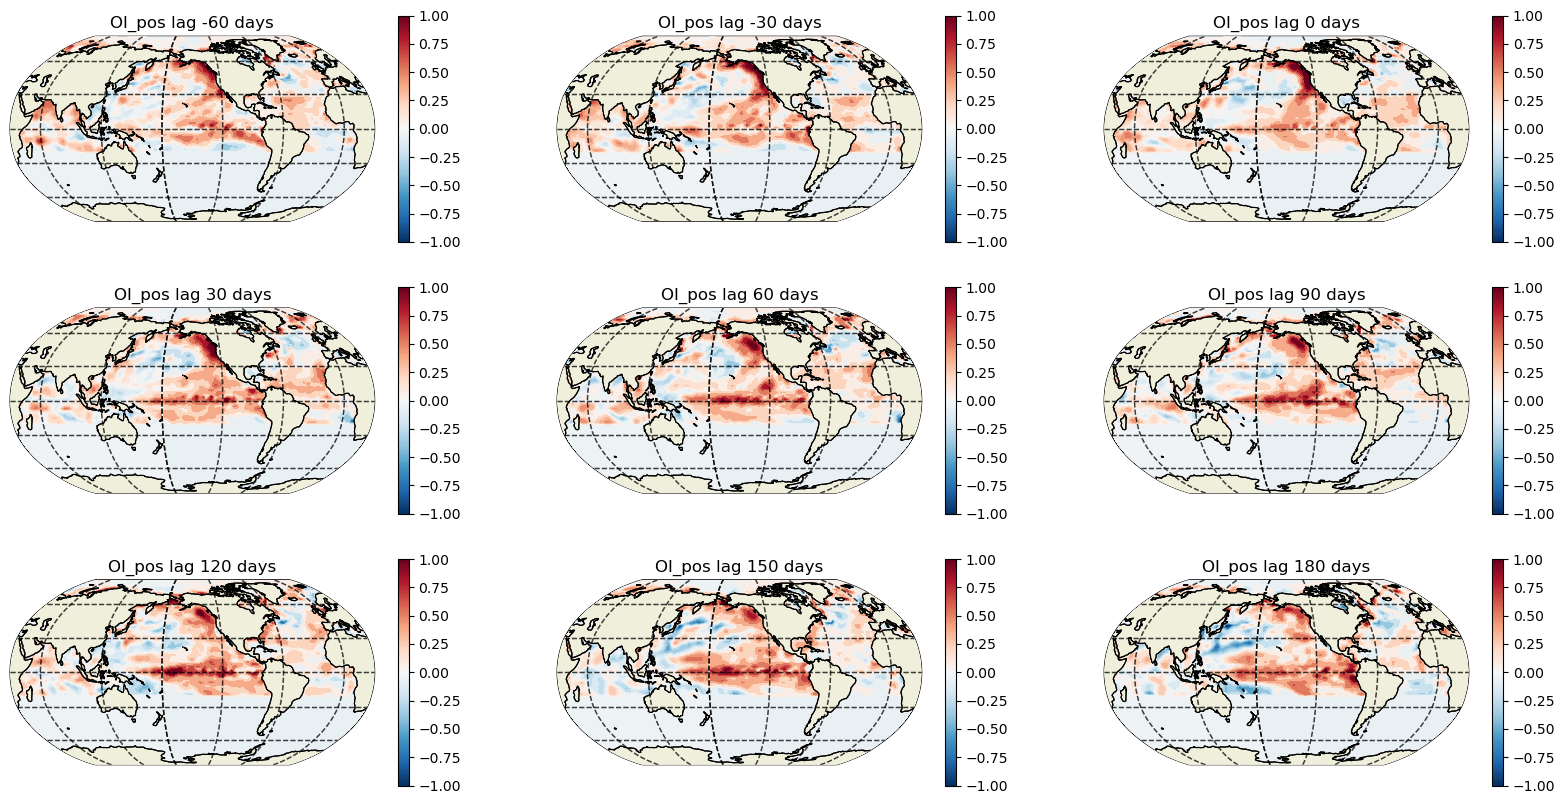

In [12]:
subplot_idx = 1
plt.rcParams["figure.figsize"] = (20,10)

for lag in lagStepsList:
    
    P = ecco.plot_proj_to_latlon_grid(ds.XC, ds.YC,
                                      OI_dict[f'lag{lag}'],
                                      plot_type = 'contourf',
                                      show_colorbar=True, cmap='RdBu_r', 
                                      cmin = -1, cmax = 1,
                                      user_lon_0 = -150,
                                      dx=2, dy=2, projection_type = 'robin',
                                      less_output = True, subplot_grid = [3,3,subplot_idx])

    P[1].set_title(f"OI_pos lag {lag} days")
    subplot_idx += 1

# plt.title("Optimal Inputs")
plt.show()

In [13]:
ds_oi = xr.Dataset()

ds_oi = ds_oi.assign(OI_minus60 = xr.DataArray(OI_dict['lag-60']),
                     OI_minus30 = xr.DataArray(OI_dict['lag-30']),
                     OI_0  = xr.DataArray(OI_dict['lag0']),
                     OI_30 = xr.DataArray(OI_dict['lag30']),
                     OI_60 = xr.DataArray(OI_dict['lag60']),
                     OI_90 = xr.DataArray(OI_dict['lag90']),
                     OI_120 = xr.DataArray(OI_dict['lag120']),
                     OI_150 = xr.DataArray(OI_dict['lag150']),
                     OI_180 = xr.DataArray(OI_dict['lag180']))

ds_oi.to_netcdf('LRP_output_forHelen/OI_v4r5_pos_newAnomalies_shuffleVal_reweight_avgInit_savedNN.nc')